In [14]:
import sys
import torch
import numpy as np
from os.path import abspath, dirname
sys.path.append('.')
import matplotlib.cm as cm
from tqdm import tqdm
%matplotlib inline

In [2]:
from load_data import SparseDataset
from models.superpoint import SuperPoint
from models.superglue import SuperGlue
from models.utils import plot_image_pair, plot_keypoints, plot_matches

In [31]:
superpoint = SuperPoint({'nms_radius': 4,  # SuperPoint Non Maximum Suppression (NMS) radius (Must be positive)
                         'keypoint_threshold': 0.005,  # SuperPoint keypoint detector confidence threshold
                         'max_keypoints': 512})

superglue = SuperGlue({
    'weights': '/home/ubuntu/SuperGlue-pytorch/outputs/2021-03-26/15-09-49/checkpoints/epoch=178-step=4474.ckpt',
    'match_threshold': 0.0,
    'sinkhorn_iterations': 100
}).cuda()
data = SparseDataset('data/COCO2014/val2014/',
                                       512,
                                       [640, 480],
                                       True,
                                       2,
                                       superpoint)
data_loader = torch.utils.data.DataLoader(dataset=data, shuffle=False, batch_size=16, drop_last=True)

Loaded SuperPoint model
Loaded SuperGlue model ("/home/ubuntu/SuperGlue-pytorch/outputs/2021-03-26/15-09-49/checkpoints/epoch=178-step=4474.ckpt" weights)


In [33]:
acc = []
for batch in (data_loader):
    
    batch = {k: torch.tensor(v).cuda() for  k, v in batch.items() if not isinstance(v, list)}
    batch = superglue._discard_empty(batch)
    
    with torch.no_grad():
        outputs = superglue(batch)
        
    if outputs['skip_train']:
        continue
        
    d = {k: v.cpu().numpy() for  k, v in batch.items() if not isinstance(v, list)}
#     print(len(d['keypoints0']))
    out = {k: v.cpu().numpy() for  k, v in outputs.items() if isinstance(v, torch.Tensor)}
    
    gt_kpts0, gt_kpts1 = d['keypoints0'], d['keypoints1']
    gt_matches, gt_conf = d['all_matches'], d['all_matches_mask']
    gt_valid = gt_conf > 0.0
    
    kpts0, kpts1 = d['keypoints0'], d['keypoints1']
    matches, conf = out['matches0'], out['matching_scores0']
    est_matches = np.stack([np.repeat(np.expand_dims(np.arange(0, matches.shape[1]), 0), matches.shape[0], axis=0), matches], 1)
    est_matches = np.transpose(est_matches, (0, 2, 1))
    valid = (matches > 0.0)
    
    for b, (est_m, gt_m) in enumerate(zip(est_matches, gt_matches)):
        acc.append(len([m for m in est_m[valid[b]] if m in gt_m[gt_valid[b]]]) / len(gt_m[gt_valid[b]]))
    
    print(np.mean(acc))

/home/ubuntu/SuperGlue-pytorch/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


0.1358288306870163
0.08928986721442363
0.0693206110211542
0.06186286954694439
0.06566985981439609
0.06019340418245883
0.07305952156507378
0.07451029680844976
0.07756445236639076
0.078357187247822
0.07886960296713529
0.083311212270423
0.0810416247297468
0.08033805739511406
0.07859482890030325
0.07810121773655673
0.07548331972737914
0.07539365519787584
0.07490901249710495
0.07574558806471896
0.07734792210573661


ZeroDivisionError: division by zero

In [18]:
batch = next(iter(data_loader))

batch = {k: torch.tensor(v).cuda() for  k, v in batch.items() if not isinstance(v, list)}
batch = superglue._discard_empty(batch)

with torch.no_grad():
    outputs = superglue(batch)

/home/ubuntu/SuperGlue-pytorch/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
d = {k: v.cpu().numpy()[0] for  k, v in batch.items() if not isinstance(v, list)}
out = {k: v.cpu().numpy()[0] for  k, v in outputs.items() if isinstance(v, torch.Tensor) and len(v.shape)>0}

In [20]:
len(batch['keypoints0']), len(outputs['matches0'])

(14, 14)

In [21]:
image0, image1 = d['image0'][0] * 255., d['image1'][0] * 255.
gt_kpts0, gt_kpts1 = d['keypoints0'], d['keypoints1']
gt_matches, gt_conf = d['all_matches'], d['all_matches_mask']
gt_valid = gt_conf > 0.0
gt_mkpts0 = gt_kpts0[gt_matches[gt_valid, 0]]
gt_mkpts1 = gt_kpts1[gt_matches[gt_valid, 1]]
gt_mconf = gt_conf[gt_valid]

In [22]:
image1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

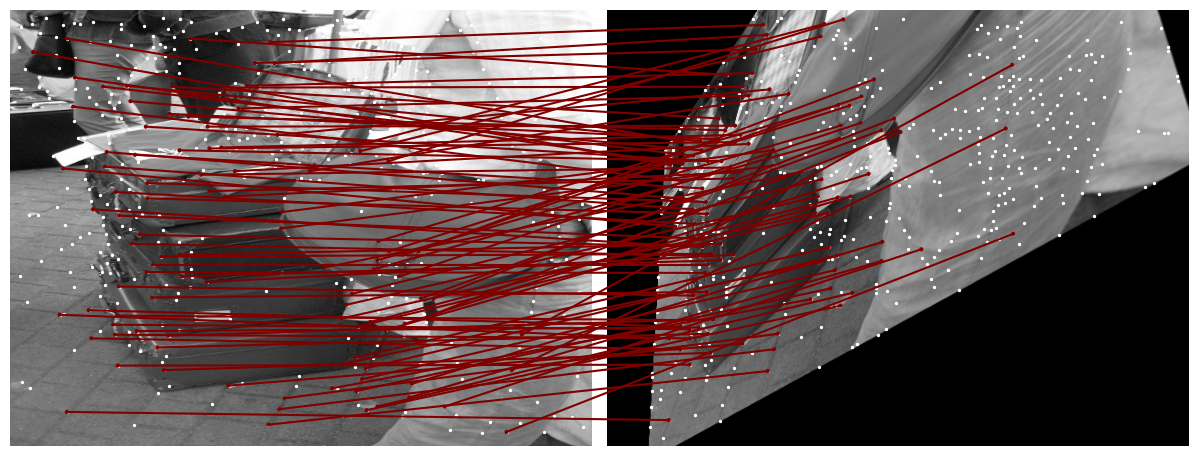

In [23]:
n_pts = 100
plot_image_pair([image0, image1])
plot_keypoints(gt_kpts0, gt_kpts1)
plot_matches(gt_mkpts0[:n_pts], gt_mkpts1[:n_pts], color=cm.jet(gt_mconf[:n_pts]))

In [24]:
threshhold = 0.0
kpts0, kpts1 = d['keypoints0'], d['keypoints1']
matches, conf = out['matches0'], out['matching_scores0']
est_matches = np.stack([np.arange(0, len(matches)), matches], 1)
valid = (matches > 0.0) & (conf > threshhold)
mkpts0 = kpts0[est_matches[valid, 0]]
mkpts1 = kpts1[est_matches[valid, 1]]
mconf = conf[valid]

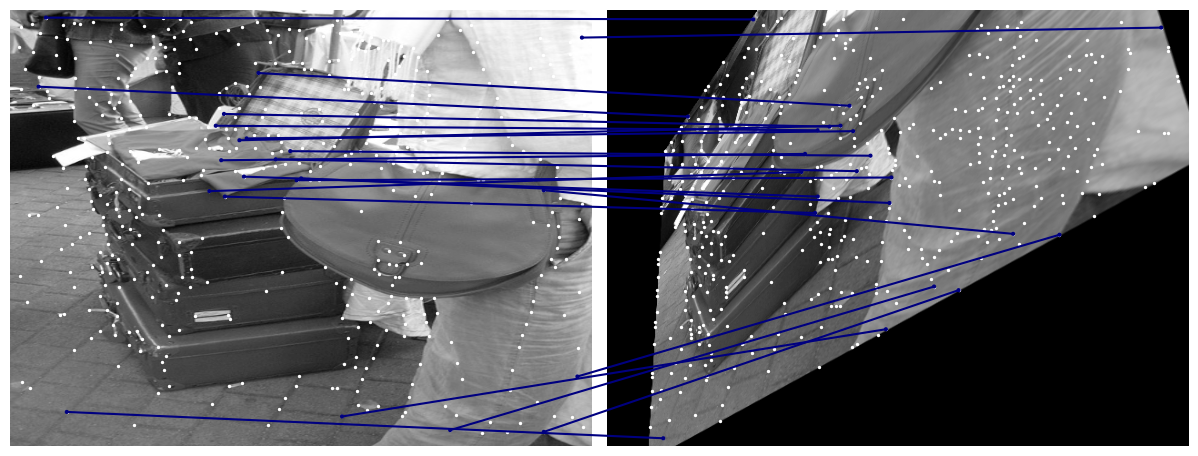

In [26]:
n_pts = 100
plot_image_pair([image0, image1])
plot_keypoints(kpts0, kpts1)
plot_matches(mkpts0[:n_pts], mkpts1[:n_pts], color=cm.jet(mconf[:n_pts]))

In [27]:
len([m for m in est_matches[valid] if m in gt_matches[gt_valid]]) / len(gt_matches[gt_valid])

0.06372549019607843